# Tea Disease Prediction for AgroAI  
## Model 4: DenseNet
### Import Dependencies

In [3]:
import tensorflow as tf
from PIL import Image
import cv2, pathlib
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
import pickle
import tempfile
from sklearn.model_selection import train_test_split

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


### Load Images

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/FINAL_PROJECT/Tea.zip", 'r')
zip_ref.extractall('/content/tea')
zip_ref.close()

In [7]:
IMAGE_SIZE = 224
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
CHANNELS = 3
BATCH_SIZE = 64
INPUT_SHAPE2 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [8]:
# Set up the base directory
base_dir = "/content/tea"

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            base_dir,
            labels = 'inferred',
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE,
            color_mode = 'rgb'
)

Found 28824 files belonging to 6 classes.


In [10]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [11]:
classes = dataset.class_names
classes

['tea algal leaf-augmented',
 'tea anthracnose-augmented',
 'tea bird eye spot-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea red leaf spot-augmented']

In [12]:
len(dataset)

451

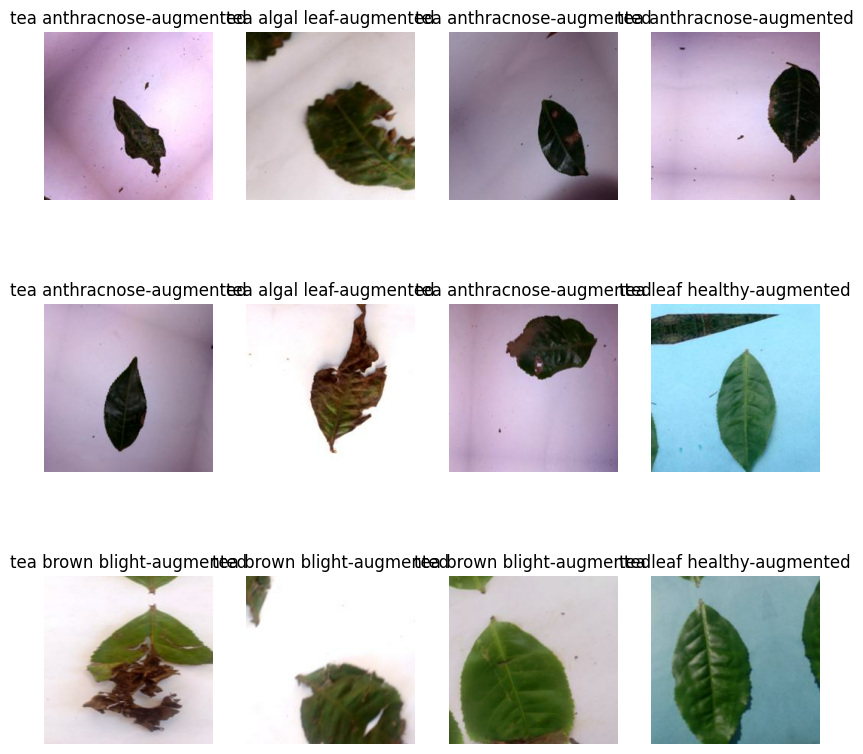

In [13]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [14]:
len(dataset) * 64

28864

### Data Splitting

In [15]:
def data_split(data, train_split = 0.8, val_split = 0.15, 
               test_split = 0.05, shuffle=True, shuffle_size = 10000):
    data_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed=8)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = data_split(dataset)

In [17]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 360

Length of Validation Dataset is 67

Length of Testing Dataset is 24


### Image Augmentation

Since ImageDataGenerator is deprecated as of Tensorflow >=2.5, we can use the Keras Layers Experimental Preprocessing API to apply the image augmentations instead.

In [18]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
#def preprocessing(ds):
#  for images, labels in ds:
#    images /= 255.0

#  return tf.image.resize(images,[224,224]), tf.one_hot(labels, 3)

In [ ]:
#train_ds = preprocessing(train_ds)

In [ ]:
#val_ds = preprocessing(val_ds)

In [ ]:
#print(train_ds)

In [19]:
type(train_ds)

tensorflow.python.data.ops.take_op._TakeDataset

In [20]:
def resize(ds):
    resizing_rescaling = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(224,224),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
    ])

    return resizing_rescaling

In [21]:
resizing_rescaling = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

In [22]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                            interpolation = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

    return data_augmentation

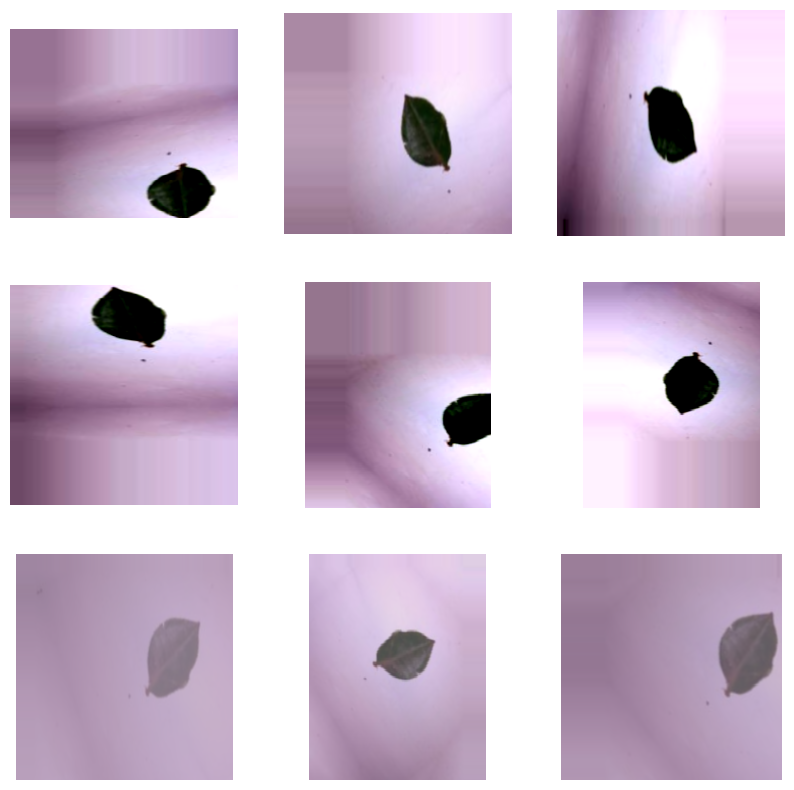

In [23]:
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [24]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                        interpolation = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

### Init Methods

In [25]:
def conf_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

  ax.set_title('Confusion Matrix with labels\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.set_xticks()
  ax.xaxis.set_ticklabels(source_classes, rotation=45)
  ax.yaxis.set_ticklabels(source_classes, rotation=45)

  plt.show()

In [26]:
saved_model_dir = "saved_model"
saved_model_his = "saved_model_history"
tflite_model_dir = "tflite_model"

if not(os.path.isdir(saved_model_dir)): os.mkdir(saved_model_dir)
if not(os.path.isdir(saved_model_his)): os.mkdir(saved_model_his)
if not(os.path.isdir(tflite_model_dir)): os.mkdir(tflite_model_dir)

In [25]:
# save model method
def saved_model(modelname, model):
  export_path = os.path.join(saved_model_dir, modelname)
  if os.path.isdir(export_path):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(export_path, ignore_errors=True)

  model.save(export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# save model history method
def saved_model_history(modelname, history):
  with open(os.path.join(saved_model_his, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [26]:
# convert saved model to TFLite model
def tflite_model_convert(modelname, tflitedir):
  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(saved_model_dir, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_model_dir, tflitedir)

  if os.path.isdir(tflite_dir):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(tflite_dir, ignore_errors=True)

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "leaf_{}.tflite".format(tflitedir.lower()))
  label_file = os.path.join(tflite_dir, "leaf_{}.txt".format(tflitedir.lower()))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(name_classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [27]:
# save all model with simplify function
def save_all_model(modelname, model, history):
  # save model
  saved_model(modelname, model)

  # save history as dict
  saved_model_history(modelname, history)

  # save best model
  #best_model = tf.keras.models.load_model('best_{}.h5'.format(modelname))
  #best_modelname = "BestMC_{}".format(modelname)
  #saved_model(best_modelname, best_model)
  # clear best model h5 format
 # os.remove('best_{}.h5'.format(modelname))

  # save tflite best model
  #tflite_model_convert(best_modelname, modelname)

### Model 4: DenseNet

In [28]:
# Get a single batch from the dataset
batch = next(iter(train_ds))

input_data = batch[0]

# Print the shape of the data in the batch
print(input_data.shape)

(64, 224, 224, 3)


In [29]:
len(classes)

6

In [30]:
from tensorflow.keras.applications.densenet import DenseNet121

pre_trained_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)


pre_trained_model.trainable = False

In [31]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [32]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = preprocess_input(inputs)
#x = data_augmentation(x)
#x = mbnet_v2(x, training=False)
x = pre_trained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
predict = tf.keras.layers.Dense(6, activation = 'softmax')(x)

model4 = tf.keras.Model(inputs = inputs, outputs = predict)

In [33]:
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [34]:
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
        elif(logs.get('val_accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True


callbacks = EarlyStoppingAtMaxAccuracy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

In [35]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [36]:
history4 = model4.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[callbacks]
)

Epoch 1/100
360/360 [==============================] - 117s 244ms/step - loss: 0.3243 - accuracy: 0.8700 - val_loss: 0.1318 - val_accuracy: 0.9471
Epoch 2/100
360/360 [==============================] - 95s 237ms/step - loss: 0.1365 - accuracy: 0.9470 - val_loss: 0.1031 - val_accuracy: 0.9615
Epoch 3/100
360/360 [==============================] - 94s 233ms/step - loss: 0.0981 - accuracy: 0.9633 - val_loss: 0.0539 - val_accuracy: 0.9818
Epoch 4/100
360/360 [==============================] - 95s 236ms/step - loss: 0.0773 - accuracy: 0.9717 - val_loss: 0.0492 - val_accuracy: 0.9844
Epoch 5/100
360/360 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9753
Accuracy is high so cancelling training!
360/360 [==============================] - 93s 234ms/step - loss: 0.0662 - accuracy: 0.9753 - val_loss: 0.0285 - val_accuracy: 0.9901


In [37]:
model4.save('DenseNet121Model_tea.h5')

In [38]:
score_train = model4.evaluate(train_ds)
score_valid = model4.evaluate(val_ds)
score_test = model4.evaluate(test_ds)

24/24 [==============================] - 15s 173ms/step - loss: 0.0206 - accuracy: 0.9954


In [39]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

In [40]:
print("Accuracy: {}".format(acc[-1]))
print("Validation Accuracy: {}".format(val_acc[-1]))

print("Loss: {}".format(loss[-1]))
print("Validation Loss: {}".format(val_loss[-1]))

Accuracy: 0.975260853767395
Validation Accuracy: 0.9901130199432373
Loss: 0.06618582457304001
Validation Loss: 0.028547223657369614


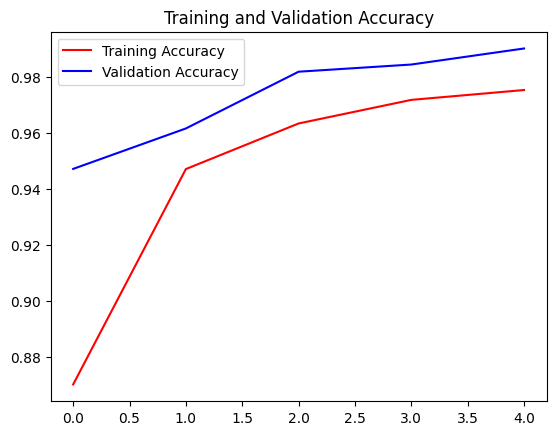

<Figure size 640x480 with 0 Axes>

In [41]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

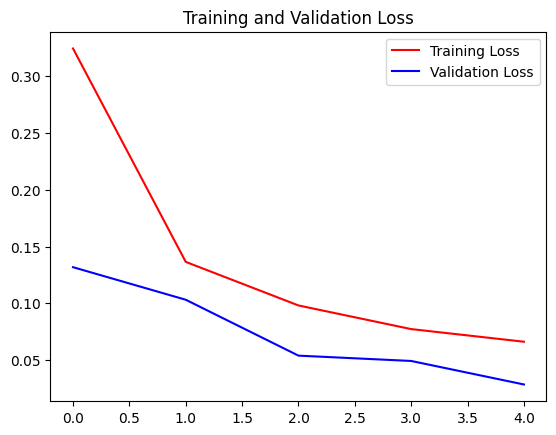

<Figure size 640x480 with 0 Axes>

In [42]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

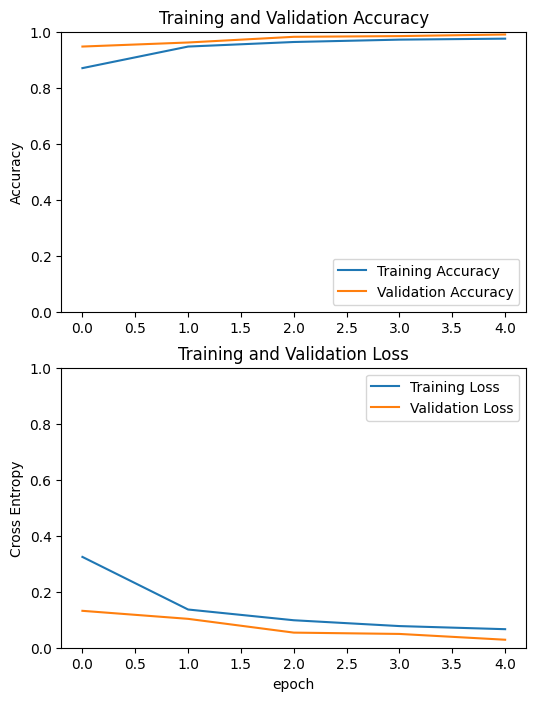

In [43]:
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to predict
actual label: tea leaf healthy-augmented
2/2 [==============================] - 4s 19ms/step
predicted label: tea leaf healthy-augmented


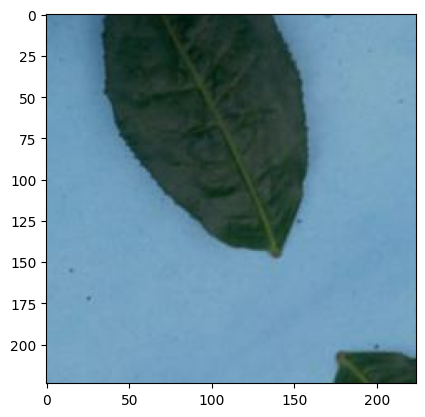

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model4.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [45]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


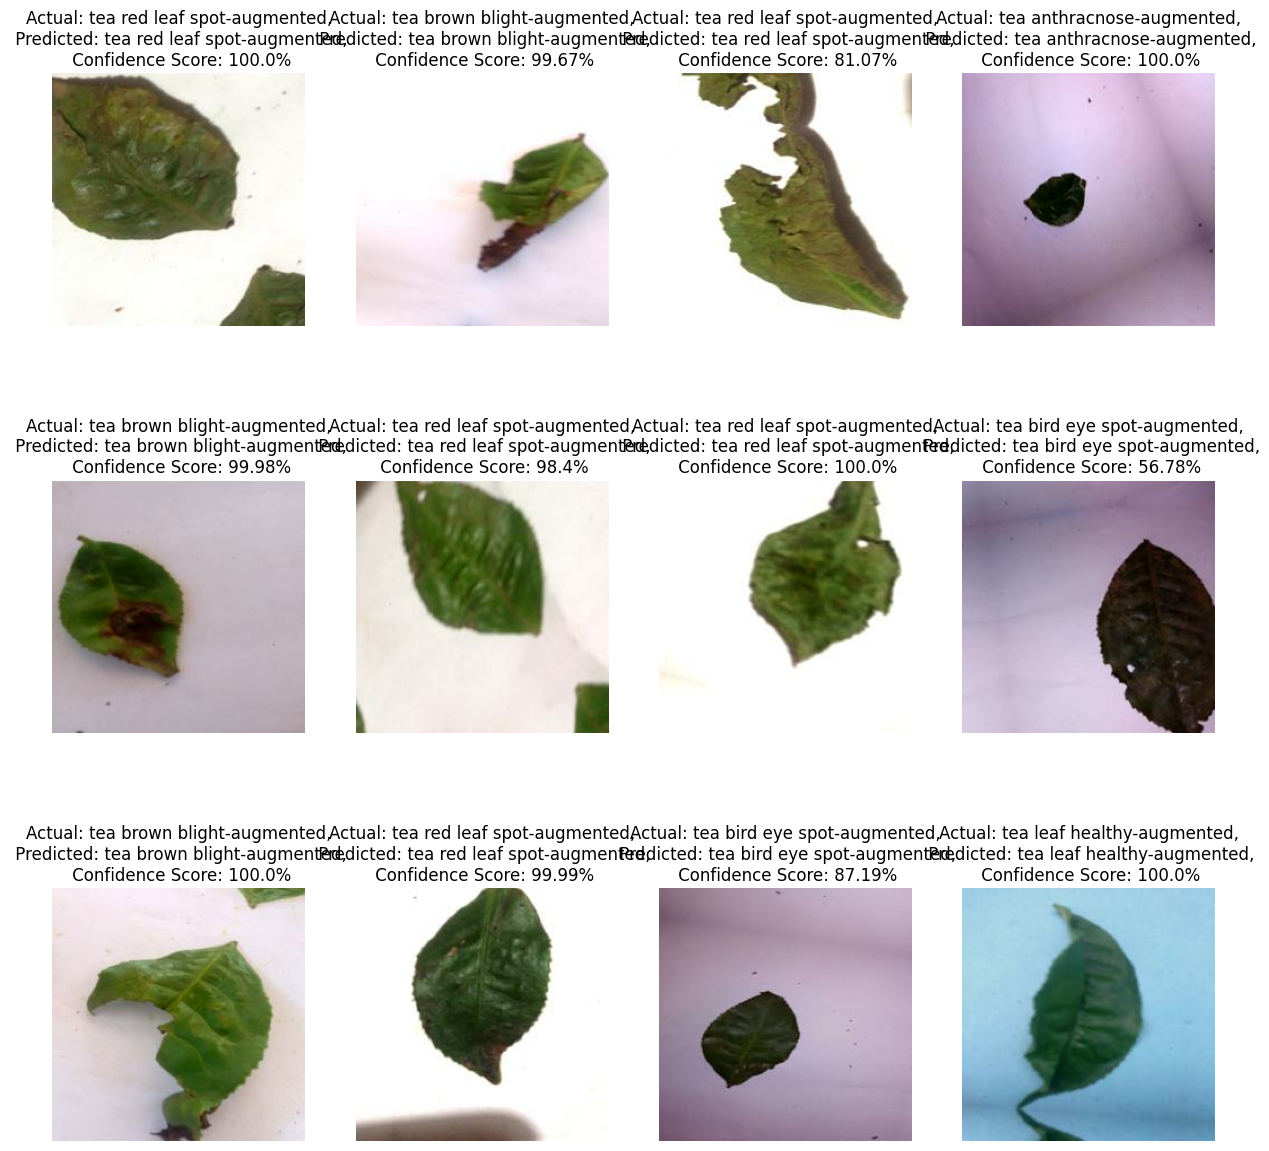

In [46]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model4,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [47]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model4,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

1/1 [==============================] - 0s 30ms/step


In [48]:
act_class

['tea brown blight-augmented',
 'tea algal leaf-augmented',
 'tea anthracnose-augmented',
 'tea anthracnose-augmented',
 'tea brown blight-augmented',
 'tea bird eye spot-augmented',
 'tea leaf healthy-augmented',
 'tea anthracnose-augmented',
 'tea leaf healthy-augmented',
 'tea brown blight-augmented',
 'tea algal leaf-augmented',
 'tea algal leaf-augmented',
 'tea anthracnose-augmented',
 'tea algal leaf-augmented',
 'tea algal leaf-augmented',
 'tea brown blight-augmented',
 'tea bird eye spot-augmented',
 'tea bird eye spot-augmented',
 'tea bird eye spot-augmented',
 'tea leaf healthy-augmented',
 'tea algal leaf-augmented',
 'tea algal leaf-augmented',
 'tea anthracnose-augmented',
 'tea leaf healthy-augmented',
 'tea algal leaf-augmented',
 'tea red leaf spot-augmented',
 'tea leaf healthy-augmented',
 'tea leaf healthy-augmented',
 'tea bird eye spot-augmented',
 'tea leaf healthy-augmented',
 'tea bird eye spot-augmented',
 'tea anthracnose-augmented',
 'tea red leaf spot-aug

In [51]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [52]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

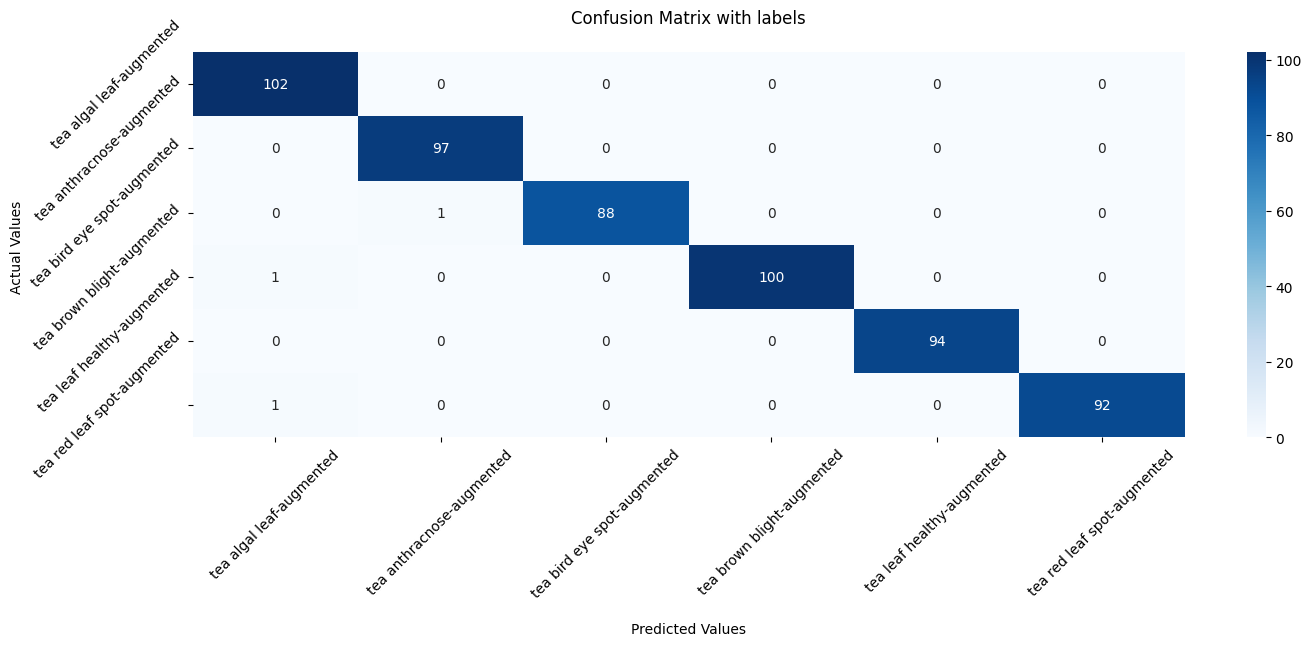

In [53]:
plot_confusion_matrix(cm = cm, classes = classes)

In [54]:
def saved_model(model_path, modelname, model):
  export_path = os.path.join(model_path, modelname)
  model.save(export_path)
  #tf.saved_model.save(model, export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# function to saved_model_history
def saved_model_history(model_path, modelname, history):
  with open(os.path.join(model_path, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# function to save tflite
def tflite_model_convert(model_path, tflite_path, modelname):

  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(model_path, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_path, "{}".format(modelname))

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "{}.tflite".format(modelname))
  
  label_file = os.path.join(tflite_dir, "{}.txt".format(modelname))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [55]:
model_path = "/content/drive/MyDrive/FINAL_PROJECT/TEA/DenseNet/saved_model"
os.makedirs(model_path, exist_ok=True)
modelname = "DenseNet_Tea"
saved_model(model_path, modelname, model4)

Export path:  /content/drive/MyDrive/FINAL_PROJECT/TEA/DenseNet/saved_model/DenseNet_Tea
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [56]:
model_path = "/content/drive/MyDrive/FINAL_PROJECT/TEA/DenseNet/saved_histori"
os.makedirs(model_path, exist_ok=True)
modelname = "DenseNet_Tea"
saved_model_history(model_path, modelname, history4)

In [57]:
# pemanggilan fungsi tflite
model_path = "/content/drive/MyDrive/FINAL_PROJECT/TEA/DenseNet/saved_model"
modelname = "DenseNet_Tea"
tflite_path = "/content/drive/MyDrive/FINAL_PROJECT/TEA/DenseNet/saved_tflite"
os.makedirs(tflite_path, exist_ok=True)

tflite_model_convert(model_path, tflite_path, modelname)

Export path:  /content/drive/MyDrive/FINAL_PROJECT/TEA/DenseNet/saved_tflite/DenseNet_Tea
['DenseNet_Tea.tflite', 'DenseNet_Tea.txt']


In [ ]:
model4 = tf.keras.models.load_model('/content/drive/MyDrive/FINAL_PROJECT/POTATO/DenseNet/saved_model/DenseNet_Tea')

Saving antharacnose tea.jpg to antharacnose tea.jpg
1/1 [==============================] - 0s 36ms/step
predictions :  [[6.6503225e-04 8.7344092e-01 1.2588505e-01 1.7140588e-06 1.3686432e-06
  5.9613358e-06]]
predicted label: tea anthracnose-augmented


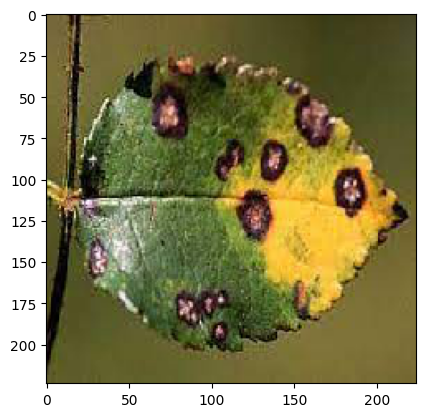

In [58]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model4.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])